In [56]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import math as math

# Load the cleaned earthquake data
file_path = '../data/Cleaned_ISC_Data.csv'
earthquake_data = pd.read_csv(file_path)

In [57]:
# earthquake_data.DATE.min()
# earthquake_data.DATE.max()

/var/folders/7l/z17fky090gggg0_sw6p28lnr0000gp/T/ipykernel_50106/3742196166.py:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


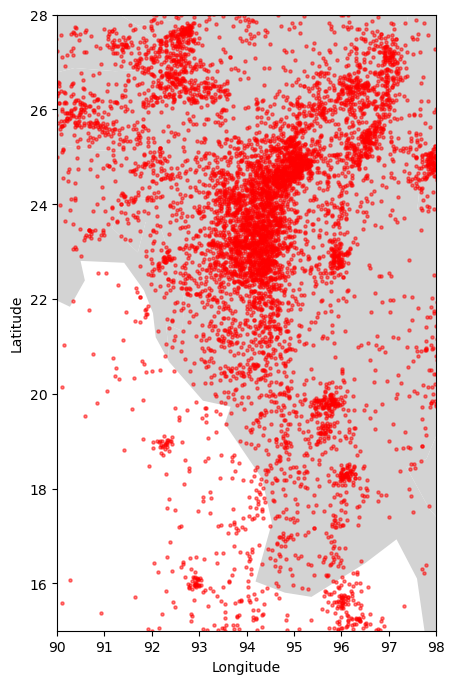

In [58]:
# Filter out rows without magnitude data and extract magnitudes as a list

# Filter earthquakes for specific depth and magnitude ranges
# min_depth = 0
# max_depth = 50
# min_magnitude = 3.6 # Mc using MAXC method
# max_magnitude = 9
# filtered_data = earthquake_data[
#     (earthquake_data['DEPTH'] >= min_depth) & 
#     (earthquake_data['DEPTH'] <= max_depth) &
#     (earthquake_data['MAG'] >= min_magnitude) &
#     (earthquake_data['MAG'] <= max_magnitude)
# ]

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(earthquake_data['LON'], earthquake_data['LAT'])]
gdf = gpd.GeoDataFrame(earthquake_data, geometry=geometry)

# Define the region of interest
minx, miny, maxx, maxy = 90, 15, 98, 28  # Example coordinates for a region in Southeast Asia

# Plot the spatial distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgray')
# Set the axis limits to the region of interest
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot the filtered earthquake data
gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.5)
# ax.set_title(f'Spatial Distribution of Earthquakes (Depth {min_depth}-{max_depth} km, Magnitude {min_magnitude}-{max_magnitude}) in the Selected Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Calculating the frequency-magnitude distribution (FMD)

source: https://github.com/sachalapins/bvalues/blob/main/bvalues.ipynb

In [59]:
# Frequency-magnitude distribution function (Mignan & Woessner article)

# mag: catalogue of magnitudes
# mbin: magnitude bin size

def fmd(mag, mbin):
    minmag = math.floor(min(mag/mbin)) * mbin # Lowest magnitude bin
    maxmag = math.ceil(max(mag/mbin)) * mbin # Highest magnitude bin
    mi = np.arange(minmag, maxmag + mbin, mbin) # Sequence of magnitude bins
    nbm = len(mi) # No. of magnitude bins
    cumnbmag = np.zeros(nbm) # Pre-allocate array for cumulative no. of events in mag bin and higher

    # Get cumulative no. of events in mag bin and higher
    for i in range(nbm):
        cumnbmag[i] = np.where(mag > mi[i] - mbin/2)[0].shape[0]
        
    # Get no. of events in each mag bin:
    nbmag = abs(np.diff(np.append(cumnbmag, 0)))
    
    return mi, nbmag, cumnbmag # Return magnitude bins, no. of events in bin, and cumulative no. of events

In [60]:
# Get FMD for moment magnitude (mw) estimates
cat_mi, cat_nbmag, cat_cumnbmag = fmd(mag = earthquake_data['MAG'], mbin = 0.1)

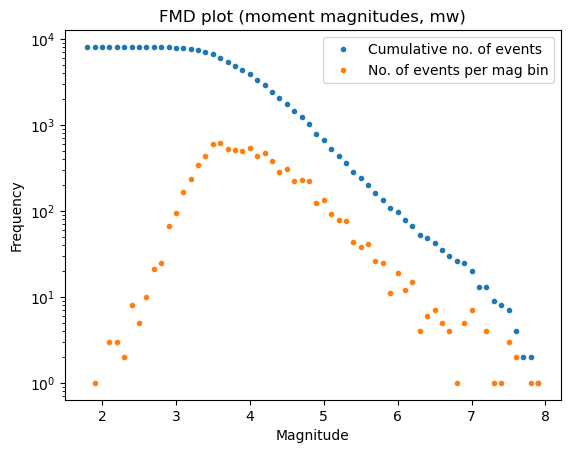

In [61]:
plt.plot(cat_mi, cat_cumnbmag, '.', label="Cumulative no. of events")
plt.plot(cat_mi, cat_nbmag, '.', label="No. of events per mag bin")
plt.yscale('log')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot (moment magnitudes, mw)')
plt.legend(loc="upper right")
plt.show()

## Estimating b-value (maximum likelihood)

In [62]:
# Function to estimate b-value using maximum likelihood method (Aki, 1965), original Aki error estimate (Aki, 1965), and Shi & Bolt (1982) improved uncertainty estimate: 

# mag: catalogue of magnitudes
# mbin: magnitude bin size
# mc: completeness magnitude

def b_est(mag, mbin, mc):
    
    mag_above_mc = mag[np.where(mag > round(mc,1)-mbin/2)[0]].values # Magnitudes for events larger than cut-off magnitude mc
    n = mag_above_mc.shape[0] # No of. events larger than cut-off magnitude mc
    if n < 2:
        a = np.nan
        b = np.nan
        aki_unc = np.nan
        shibolt_unc = np.nan
    else:
        mbar = np.mean(mag_above_mc) # Mean magnitude for events larger than cut-off magnitude mc
        b = math.log10(math.exp(1)) / (mbar - (mc - mbin/2)) # b-value from Eq 3
        a = math.log10(n) + b * mc # 'a-value' for Eq 2
        aki_unc = b / math.sqrt(n) # Uncertainty estimate from Eq 4
        shibolt_unc = 2.3 * b**2 * math.sqrt(sum((mag_above_mc - mbar)**2) / (n * (n-1))) # Uncertainty estimate from Eq 5

    return a, b, aki_unc, shibolt_unc # Return b-value and estimates of uncertainty

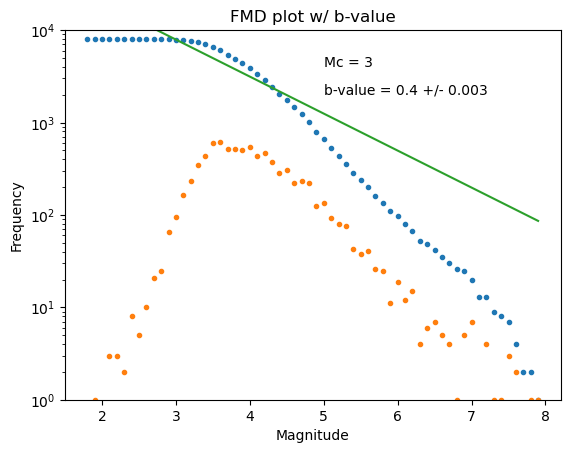

In [63]:
# Plot b-value estimate for a completeness magnitude of 3.0

cat_mc = 3
# Completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = earthquake_data['MAG'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(earthquake_data.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value')
plt.text(x=5, y=4e3, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=5, y=2e3, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()

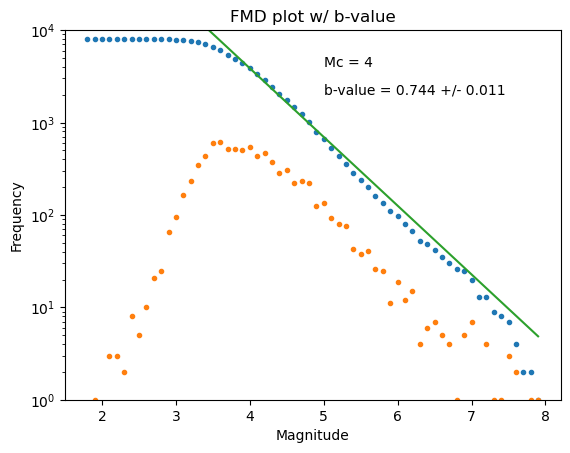

In [64]:
# Plot b-value estimate for a completeness magnitude of 4.0

cat_mc = 4
# Completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = earthquake_data['MAG'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(earthquake_data.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value')
plt.text(x=5, y=4e3, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=5, y=2e3, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()

As you can see, the b-value estimate is pretty sensitive to choice of completeness magnitude. These two values, 1 and 2, were chosen arbitrarily. I will now show you some methods for properly estimating completeness magnitude.

## Estimating completeness magnitude (Peer-reviewed methods)

Three of the most commonly used approaches for determining _Mc_ are the Maximum Curvature (MAXC) method (Weimer and Wyss, 2000), the goodness-of-fit test (GFT; Weimer & Wyss, 2000) and by b-value stability (MBS) method (Cao and Gao, 2002).

### 1. MAXC
The MAXC (Weimer and Wyss, 2000) method is the most straightforward approach, simply using the magnitude bin from the non-cumulative FMD (orange dots in figures above) containing the highest frequency of events (i.e., the peak of the orange dots). However, this approach has the highest potential to underestimate _Mc_ when detection rates vary (e.g., due to changing station availability) and will usually give the lowest estimate of all methods (Mignan & Woessner, 2012).

details: https://github.com/sachalapins/bvalues/blob/main/bvalues.ipynb

In [65]:
# Function to get completeness magnitude with MAXC method

def get_maxc(mag, mbin):
    this_fmd = fmd(mag, mbin) # FMD
    maxc = this_fmd[0][np.argmax(this_fmd[1])] # Mag bin with highest no. of events
    return round(maxc, 1)

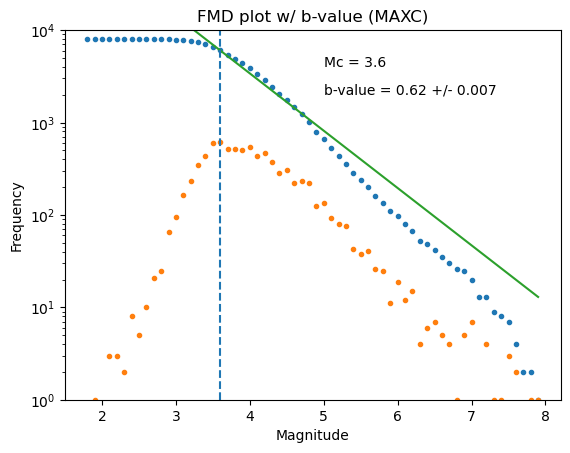

In [66]:
# Plot b-value estimate using MAXC to estimate complteness magnitude

cat_mc = get_maxc(mag = earthquake_data['MAG'], mbin = 0.1) # MAXC completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = earthquake_data['MAG'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.vlines(cat_mc, ymin=1, ymax=10**math.ceil(math.log10(earthquake_data.shape[0])), linestyles='dashed')

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(earthquake_data.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value (MAXC)')
plt.text(x=5, y=4e3, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=5, y=2e3, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()

### 2. GFT

Although more conservative than the MAXC approach, the GFT still generally produces lower estimates of _Mc_ than other methods (Mignan & Woessner, 2012; Wiemer & Wyss, 2000) due to the criterion of using the lowest _Mw_ within an acceptable confidence level. From personal experimentation, it also appears to be much least stable when catalogue sizes are small.

In [67]:
def get_gft(mag, mbin):
    this_fmd = fmd(mag, mbin) # FMD
    this_maxc = get_maxc(mag, mbin) # Needed further down

    # Zeros to accommodate synthetic GR distributions for each magnitude bin
    a = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate a values from Eq 2
    b = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate b values from Eq 2 & 3
    R = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate R values from Eq 6

    # Loop through each magnitude bin, using it as cut-off magnitude
    for i in range(this_fmd[0].shape[0]):
        mi = round(this_fmd[0][i], 1) # Cut-off magnitude
        try:
            a[i], b[i], tmp1, tmp2 = b_est(mag, mbin, mi) # a and b-values for this cut-off magnitude
        except:
            continue
        synthetic_gr = 10**(a[i] - b[i]*this_fmd[0]) # Synthetic GR for a and b
        Bi = this_fmd[2][i:] # B_i in Eq 6
        Si = synthetic_gr[i:] # S_i in Eq 6
        R[i] = (sum(abs(Bi - Si)) / sum(Bi)) * 100 # Eq 6

    # Confidence levels to test
    R_to_test = [95, 90] # (95% and 90% conf levels)

    GFT_test = [np.where(R <= (100 - conf_level)) for conf_level in R_to_test] # Test whether R within confidence level
    # Loop through and check first cut-off mag within confidence level
    for i in range(len(R_to_test)+1):
        # If no GR distribution fits within confidence levels then use MAXC instead
        if i == (len(R_to_test) + 1):
            mc = this_maxc
            print("No fits within confidence levels, using MAXC estimate")
            break
        else:
            if len(GFT_test[i][0]) > 0:
                mc = round(this_fmd[0][GFT_test[i][0][0]], 1) # Use first cut-off magnitude within confidence level
                break
    
    return mc, this_fmd[0], R

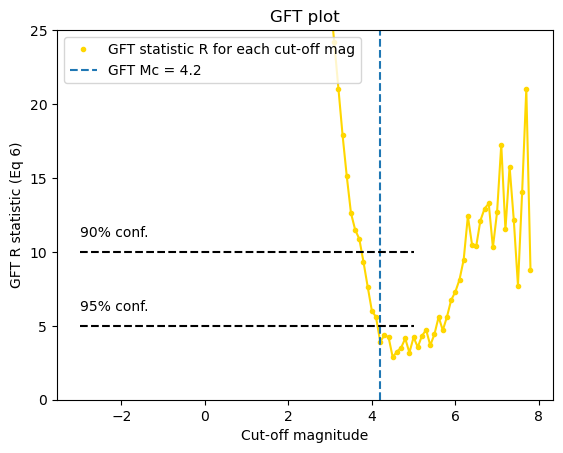

In [68]:
# Plot b-value estimates using GFT

# First, plot R goodness of fit statistic for each cut-off magnitude:
cat_gft = get_gft(mag = earthquake_data['MAG'], mbin = 0.1) # GFT completeness magnitude

plt.plot(cat_gft[1], cat_gft[2], '.', color="gold", label="GFT statistic R for each cut-off mag")
plt.plot(cat_gft[1], cat_gft[2], color="gold")

plt.vlines(cat_gft[0], ymin=0, ymax=100, linestyles='dashed', label="GFT Mc = " + str(round(cat_gft[0], 1)))
plt.hlines(5, xmin=-3, xmax=5, linestyles='dashed', colors='k')
plt.hlines(10, xmin=-3, xmax=5, linestyles='dashed', colors='k')
plt.text(x=-3, y=11, s="90% conf.")
plt.text(x=-3, y=6, s="95% conf.")
plt.ylim(0, 25)
plt.xlabel('Cut-off magnitude')
plt.ylabel('GFT R statistic (Eq 6)')
plt.title('GFT plot')
plt.legend(loc='upper left')
plt.show()

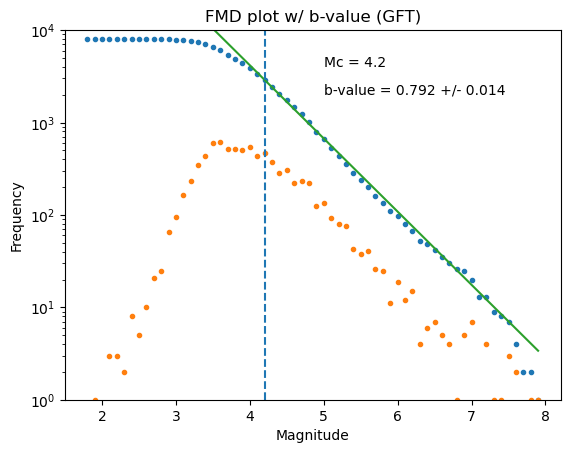

In [69]:
# Then plot GFT b-value against FMD

cat_mc = cat_gft[0] # GFT completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = earthquake_data['MAG'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.vlines(cat_mc, ymin=1, ymax=10**math.ceil(math.log10(earthquake_data.shape[0])), linestyles='dashed')

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(earthquake_data.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value (GFT)')
plt.text(x=5, y=4e3, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=5, y=2e3, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()

### 3. MBS

The MBS approach generally leads to the most conservative, or highest, estimate of _Mc_ of the three techniques (Mignan & Woessner, 2012), and thus has the lowest potential for underestimating _Mc_ in the presence of varying station availability or other sources of error.

method details: https://github.com/sachalapins/bvalues/blob/main/bvalues.ipynb

In [70]:
def get_mbs(mag, mbin, dM = 0.4, min_mc = -3):

    this_fmd = fmd(mag, mbin) # FMD
    this_maxc = get_maxc(mag, mbin) # Needed further down

    # Zeros to accommodate synthetic GR distributions for each magnitude bin
    a = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate a values from Eq 2
    b = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate b values from Eq 2 & 3
    b_avg = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate average b values from Eq 7
    shibolt_unc = np.zeros(this_fmd[0].shape[0]) # Pre-allocate array to accommodate uncertainty values from Eq 5

    # Loop through each magnitude bin, using it as cut-off magnitude
    for i in range(this_fmd[0].shape[0]):
        mi = round(this_fmd[0][i], 1) # Cut-off magnitude
        if this_fmd[2][i] > 1:
            a[i], b[i], tmp1, shibolt_unc[i] = b_est(mag, mbin, mi) # a and b-values for this cut-off magnitude
        else:
            a[i] = np.nan
            b[i] = np.nan
            shibolt_unc[i] = np.nan

    # Loop through again, calculating rolling average b-value over following dM magnitude units
    no_bins = round(dM/mbin)
    check_bval_stability = []
    for i in range(this_fmd[0].shape[0]):
        if i >= this_fmd[0].shape[0] - (no_bins + 1):
            b_avg[i] = np.nan
            next
        if any(np.isnan(b[i:(i+no_bins+1)])):
            b_avg[i] = np.nan
            check_bval_stability.append(False)
        else:
            b_avg[i] = np.mean(b[i:(i+no_bins+1)])
            check_bval_stability.append(abs(b_avg[i] - b[i]) <= shibolt_unc[i])

    if any(check_bval_stability):
        bval_stable_points = this_fmd[0][np.array(check_bval_stability)]
        mc = round(min(bval_stable_points[np.where(bval_stable_points > min_mc)[0]]), 1) # Completeness mag is first mag bin that satisfies Eq 7
    else:
        mc = this_maxc # If no stability point, use MAXC

    return mc, this_fmd[0], b, b_avg, shibolt_unc

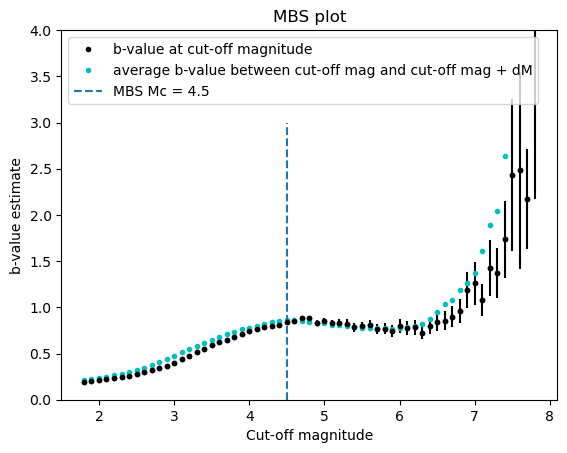

In [71]:
# Plot of MBS estimates (completeness magnitude is first abs(b_avg - b) that's within b-value uncertainty)

cat_mbs = get_mbs(mag = earthquake_data['MAG'], mbin = 0.1) # MBS completeness magnitude

plt.plot(cat_mbs[1], cat_mbs[2], '.', color='k', label="b-value at cut-off magnitude") # Black dots are b-value estimates for each cut-off magnitude
plt.errorbar(cat_mbs[1], cat_mbs[2], yerr=cat_mbs[4], fmt='.', color='k')
plt.plot(cat_mbs[1], cat_mbs[3], '.', color="c", label="average b-value between cut-off mag and cut-off mag + dM") # Cyan dots are average b-value over next few magnitude bins
plt.vlines(cat_mbs[0], ymin=0, ymax=3, linestyles='dashed', label="MBS Mc = " + str(round(cat_mbs[0], 1)))
plt.legend(loc='upper left')
plt.ylim(0, 4)
plt.xlabel('Cut-off magnitude')
plt.ylabel('b-value estimate')
plt.title('MBS plot')
plt.show()

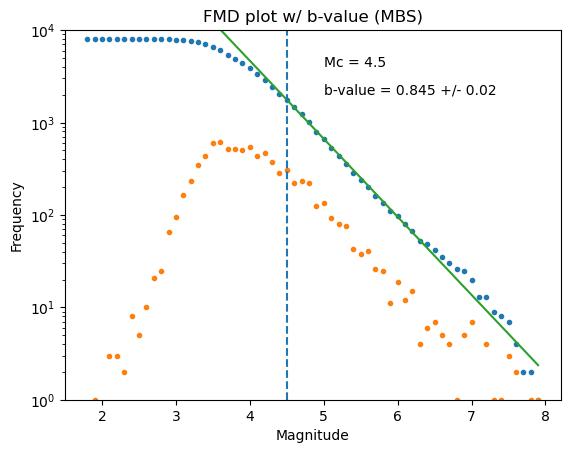

In [72]:
# FMD plot using MBS completeness magnitude for b-value:

cat_mc = cat_mbs[0] # GFT completeness magnitude
cat_a, cat_b, cat_aki_unc, cat_shibolt_unc = b_est(mag = earthquake_data['MAG'], mbin = 0.1, mc = cat_mc)

plt.plot(cat_mi, cat_cumnbmag, '.')
plt.plot(cat_mi, cat_nbmag, '.')
plt.plot(cat_mi, (10**(cat_a - (cat_b * cat_mi))))

plt.vlines(cat_mc, ymin=1, ymax=10**math.ceil(math.log10(earthquake_data.shape[0])), linestyles='dashed')

plt.yscale('log')
plt.ylim(1, 10**math.ceil(math.log10(earthquake_data.shape[0])))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('FMD plot w/ b-value (MBS)')
plt.text(x=5, y=4e3, s="Mc = " + str(round(cat_mc, 1)))
plt.text(x=5, y=2e3, s="b-value = " + str(round(cat_b, 3)) + " +/- " + str(round(cat_shibolt_unc, 3)))
plt.show()

**References**

Aki, K. (1965). Maximum likelihood estimate of b in the formula log N=a-bM and its confidence limits, Bull. Earthq. Res. Inst., Univ. Tokyo, 43, 237–239

Bender, B. (1983). Maximum likelihood estimation of b values for magnitude grouped data, BSSA, 73(3), 931-851

Cao, A. M., & Gao, S. S. (2002). Temporal variations of seismic b-values beneath northeastern Japan island arc, GRL, 29, doi:10.1029/2001GL013775

Marzocchi, W., & Sandri, L. (2003). A review and new insights on the estimation of the b-value and its uncertainty, Annals of Geophysics, 46(6), 1271-1282

Mignan, A., & Woessner, J. (2012). Estimating the magnitude of completeness for earthquake catalogs, CORSSA (url: http://www.corssa.org/export/sites/corssa/.galleries/articles-pdf/Mignan-Woessner-2012-CORSSA-Magnitude-of-completeness.pdf_2063069299.pdf)

Naylor, M., Orfanogiannaki, K., & Harte, D. (2010). Exploratory Data Analysis: Magnitude, Space, and Time, CORSSA (url: http://www.corssa.org/export/sites/corssa/.galleries/articles-pdf/Naylor-et-al-2010-CORSSA-Exploratory-data-analysis.pdf_2063069299.pdf)

Shi, Y., & Bolt, B. A. (1982). The standard error of the magnitude-frequency b value, BSSA, 72(5), 1677-1687

Wiemer, S., & Wyss, M. (2000). Minimum magnitude of complete reporting in earthquake catalogs: examples from Alaska, the western United States, and Japan, BSSA, 90, 859–869.

In [73]:
earthquake_data.head()

,EVENTID,TYPE,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,...,Extra_101,Extra_102,Extra_103,Extra_104,Extra_105,Extra_106,Extra_107,Extra_108,Extra_109,Extra_110
0,16957826,ke,ISC,30-08-1904,11:43:37.59,25.5166,97.0211,15.0,TRUE,ABE1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,914281,ke,GUTE,31-08-1906,14:57:30,27.0000,97.0000,100.0,,PAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16957984,ke,ISC,09-02-1908,18:13:17.58,29.2781,100.6556,15.0,TRUE,ISC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16958007,ke,ISC,12-12-1908,12:54:57.27,26.9477,96.7734,15.0,TRUE,ISC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16958191,ke,ISC,23-05-1912,02:24:04.06,21.0361,96.7366,15.0,TRUE,ISC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
